In [1]:
from datetime import datetime as dt
from pathlib import Path

import numpy as np
import pandas as pd

In [2]:
date_format = '%Y-%m-%d'
db_query = '~region & ISO3_CODE != "ERROR" & ISO3_CODE != "Field date" & ISO3_CODE != "NCL"'

data_dir = Path.cwd()/"data"
date_fname = "report_date.csv"
db_fname = "db_scraped.csv"

first_date = dt.strptime("2021-04-16", date_format)
first_risks = "db_20210416.csv"

In [3]:
def get_date_risk(commit_dir):
    db_df, date_df = (pd.read_csv(commit_dir/fn) for fn in (db_fname, date_fname))

    date_str = date_df["report_date"][0]
    date_dt = dt.strptime(date_str, date_format)

    db_df["region"].fillna(False, inplace=True)
    risk_codes = db_df.query(db_query)[["ISO3_CODE", "risk_level_code"]]
    risk_codes.set_index("ISO3_CODE", inplace=True)
    return risk_codes["risk_level_code"].rename(date_dt)

In [4]:
risk_rows = []

for p in sorted(Path(data_dir).iterdir()): 
        if p.is_dir():
            risk_row = get_date_risk(p)
            risk_rows.append(risk_row)

Keep only the latest risks for the same date

In [5]:
latest_date = -1
risk_dict =dict()
for rr in risk_rows:
    current_date = rr.name
    if current_date != latest_date:
        risk_dict[current_date] = rr
        latest_date = current_date

In [6]:
risk_df = pd.DataFrame(risk_dict).T
full_df = risk_df.sort_index()

Cirurgical fixes:
1. **Kosovo** `XKX`: `NaN` entries get the next filled value
2. **Palestina** `PSE`: `NaN` entries get the values from Israel `ISR`
3. **Germany** `DEU`: Gets value `5`
4. Delete overseas territories `CUW, GLP PRI`

In [7]:
full_df.drop(columns=['CUW','GLP','PRI'], inplace=True)
full_df['XKX'] = full_df['XKX'].fillna(method='bfill')
full_df['PSE'].where(~full_df['PSE'].isna(), full_df['ISR'], inplace=True)
full_df['DEU'] = 5

In [8]:
full_df = full_df.astype(int)
full_df

ISO3_CODE,AFG,AGO,ALB,AND,ARE,ARG,ARM,ATG,AUS,AUT,...,VCT,VEN,VNM,VUT,WSM,XKX,YEM,ZAF,ZMB,ZWE
2020-06-15,3,3,3,0,3,3,3,0,0,0,...,0,3,3,0,0,3,3,3,3,3
2020-06-16,3,3,3,0,3,3,3,3,0,0,...,3,3,3,0,0,3,3,3,3,3
2020-06-17,3,3,3,0,3,3,3,3,0,0,...,3,3,3,0,0,3,3,3,3,3
2020-06-19,3,3,3,0,3,3,3,3,0,0,...,3,3,0,0,0,3,3,3,3,3
2020-06-26,3,3,3,0,3,3,3,3,0,0,...,3,3,0,0,0,3,3,3,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-04,2,0,2,2,2,2,2,2,2,2,...,2,2,2,0,0,2,2,0,0,0
2022-02-11,2,0,2,2,2,2,2,2,2,2,...,0,2,2,0,0,2,2,0,0,0
2022-02-18,0,0,2,0,0,2,2,2,2,2,...,0,2,2,0,0,2,2,0,0,0
2022-02-25,0,0,0,0,0,0,2,0,0,2,...,0,2,2,0,0,0,2,0,0,0


In [9]:
full_df.to_csv('risk_date_countries.csv', date_format=date_format)

<AxesSubplot:>

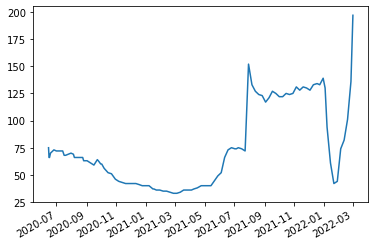

In [10]:
(full_df==0).sum(axis=1).plot()

In [17]:
commit_dir = [p for p in sorted(Path(data_dir).iterdir())][-2]

In [43]:
db_df, date_df = (pd.read_csv(commit_dir/fn) for fn in (db_fname, date_fname))

date_str = date_df["report_date"][0]
date_dt = dt.strptime(date_str, date_format)

db_df["region"].fillna(False, inplace=True)
risk_codes = db_df.query(db_query)[["ISO3_CODE", "risk_level_code"]]
risk_codes = risk_codes.set_index("ISO3_CODE").T.rename({"risk_level_code": date_dt})

merged_df = pd.concat([full_df, risk_codes])
merged_df[~merged_df.index.duplicated(keep='last')].sort_index()

ISO3_CODE,AFG,AGO,ALB,AND,ARE,ARG,ARM,ATG,AUS,AUT,...,VCT,VEN,VNM,VUT,WSM,XKX,YEM,ZAF,ZMB,ZWE
2020-06-15,3,3,3,0,3,3,3,0,0,0,...,0,3,3,0,0,3,3,3,3,3
2020-06-16,3,3,3,0,3,3,3,3,0,0,...,3,3,3,0,0,3,3,3,3,3
2020-06-17,3,3,3,0,3,3,3,3,0,0,...,3,3,3,0,0,3,3,3,3,3
2020-06-19,3,3,3,0,3,3,3,3,0,0,...,3,3,0,0,0,3,3,3,3,3
2020-06-26,3,3,3,0,3,3,3,3,0,0,...,3,3,0,0,0,3,3,3,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-04,2,0,2,2,2,2,2,2,2,2,...,2,2,2,0,0,2,2,0,0,0
2022-02-11,2,0,2,2,2,2,2,2,2,2,...,0,2,2,0,0,2,2,0,0,0
2022-02-18,0,0,2,0,0,2,2,2,2,2,...,0,2,2,0,0,2,2,0,0,0
2022-02-25,0,0,0,0,0,0,2,0,0,2,...,0,2,2,0,0,0,2,0,0,0


In [35]:
risk_codes

ISO3_CODE,AFG,AGO,ALB,AND,ARE,ARG,ARM,ATG,AUS,AUT,...,VCT,VEN,VNM,VUT,WSM,XKX,YEM,ZAF,ZMB,ZWE
2021-04-16,3,3,2,2,3,2,2,3,0,3,...,0,3,0,0,0,2,3,1,1,1
